# _**Cuaderno Solución - Prueba Técnica - Platzi**_
- **Desarrollado por:** Nicolás Guerrero Caballero
- **Objetivo:** Optar por el cargo de Científico de Datos

## **Contexto**
Imagina que eres un científico de datos en una startup que ofrece una suscripción mensual para cursos, talleres y
contenido profesional en línea. Los usuarios disfrutan de una biblioteca de cursos, herramientas interactivas y
soporte personalizado en continua expansión. Su tarea es aprovechar la ciencia de datos para proporcionar información
y crear modelos que fomenten la retención de usuarios.

## **Notas:**
1. El dashboard que ayudó a solucionar la siguiente prueba se encuentra en el siguiente [link](https://lookerstudio.google.com/u/0/reporting/50c65a8a-816c-4787-a8ca-3f4a1bc7f532/).
2. Los datos fueron cargados a Cloud Storage se consultaron a través de BigQuery mediante consultas SQL, las cuales encontrará en el looker (si hace una copia) o en el documento de texto querys.txt en este mismo repositorio.

# _**Preguntas de los Stakeholders:**_

## **¿Cuál fue la tasa de retención (Retention Rate) en el primer trimestre 2024?**

La tasa de retención nos indica de los usarios que tenemos al inicio de un periodo (diario, menasual, trimestral, anual, etc.) cuántos mantenemos al final de ese mismo periodo. Traducido a nuestro caso de negocio, indica cuántos usuarios que tenían una subscripción activa a inicios de enero de 2024, mantienen su subscripción para marzo del mismo año.  

En primer lugar, luego de analizar los datos parece que todas las subscripciones tienen una periodicidad mensual, es decir, cada subscripción se renueva cada mes. Para calcular la tasa de retención existen diversas formulas, la más común es:


$
RetentionRate = \frac{\text{Clientes al final del Q } - \text{ Clientes nuevos adquiridos durante el Q}}{\text{Clientes al inicio del Q}}
$


Donde:
 - **Clientes al Final del Q:** Son los clientes que renovaron en marzo, pues estos tendrán una subscripción activa al final del periodo, es decir, el 31 de marzo.
 - **Clientes nuevos adquiridos durante el Q:** Clientes cuya primera facturación se realizó en enero, febrero o marzo de 2024.
 - **Clientes al inicio del Q:** Aquí puede haber discrepacias puesto que pueden ser los clientes que renovaron en diciembre, por lo que su subscripción estará activa el primer día de enero o pueden ser los clientes que renovaron en enero. **En este caso nos decantaremos por la primera** al ser la opción más fuel a la definición de la tasa.

### **Solución:**

<p align="center">
  <img src=".\images\retention_rate.png">
</p>


- La tasa de retención para el primer Q es de **25.25%**, con 2586 subscripciones activas el 1 de enero, 2217 subcriociones nuevas y 2870 subscripciones activas en marzo 31.

- **Otra Forma:** También se puede ver la tasa de retención tomando el número de subscripciones nuevas en enero y registrando de todas estas, cuántas siguieron renovando su subscripción en marzo. Siguiendo esta definición la tasa de retención será de **39.26%** copn 754 usuarios nuevos en enero y 296 de esos usuarios que renovaron en marzo de 2024.



## **Determine el número de subscriptores en abril de 2024**

El número de subcripciones en abril de 2024 fue de **2.539** de los cuales 748 fueron subscripciones nuevas, es decir el 29.46%

<p align="center">
  <img src=".\images\subscriptions.png">
</p>


## **Desarrolle un análisis de cohorte para evaluar el riesgo de abandono de los usuarios que renuevan en mayo**

<p align="center">
  <img src=".\images\cohort_analysis.png">
</p>

Dada la información historica, se obtienen las siguientes conclusiones:

1. Entre el 40% y el 45% de los usuarios nuevos que se registren en la plataforma en mayo de 2024, muy probablemente no renovarán su subscripción el siguiente més y solamente entre el 10% y el 15% llegarán a renovar su subscripción en el mes 6. 
2. El 70% de los usuarios que lleguen en mayo, serán renovaciones de meses anteriores (ver gráfico 2) y la mayoría de usuarios estará inscrito entre diciembre de 2023 y abril de 2024 que en promedio tienen una tasa de abandono de 60% al 70%. 

De esto se infiere que para el final del año, sólo un 10% de los usuarios inscritos en mayo seguirán en la plataforma, asumiento que la tasa de retención no mejora significativamente.

**Nota:** En el siguiente apartado se desarrolla un modelo de arboles de decisión con el fin de predecir el numero de veces que el usuario renovará su subscripción, o en otras palabras, el número de meses que se espera que el usuario esté en la plataforma con base en sus patrones de consumo del contenido.

## **Desarrolle estrategias para mejorar la retención de los usuarios**

### **Análisis de Datos**

#### Librerías

In [90]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import tree

#### Importamos la información

In [91]:
# Importar la información
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9801 entries, 0 to 9800
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              9801 non-null   int64  
 1   med_active_days      9801 non-null   int64  
 2   avg_active_days      9801 non-null   float64
 3   med_courses_seen     9801 non-null   int64  
 4   avg_courses_seen     9801 non-null   float64
 5   med_materials_seen   9801 non-null   int64  
 6   avg_materials_seen   9801 non-null   float64
 7   favorite_category    9780 non-null   object 
 8   subscription_number  9801 non-null   int64  
 9   renewed              9801 non-null   int64  
 10  age                  9801 non-null   int64  
 11  is_working           9505 non-null   float64
dtypes: float64(4), int64(7), object(1)
memory usage: 919.0+ KB


#### Featuring Engineering 

En primer lugar identificaremos si conviene más trabajar con la variable _"subscription_number"_ o _"renewed"_ para realizar el análisis de correlaciones. Si bien a priori tiene sentido trabajar con la variable _"renewed"_, al ser binaria su variabilidad es baja y puede ocultar patrones utiles en el análisis. Esto lo podemos ver en el siguiente gráfico, donde se muestra una relación muy clara entre la cantidad de cursos, la cantida de días activos y la cantidad de materiales vistos con las veces de renovación. Como se observa, cuando los usuarios ven una cantidad media de materiales, cursos, etc. tienen a renovar más. Incluso el patrón es más claro al ver la variable _"is_working"_, donde se ve que las personas que trabajan tienden a renovar más que las que no, patrón que se oculta cuando se usa _"renewed"_.

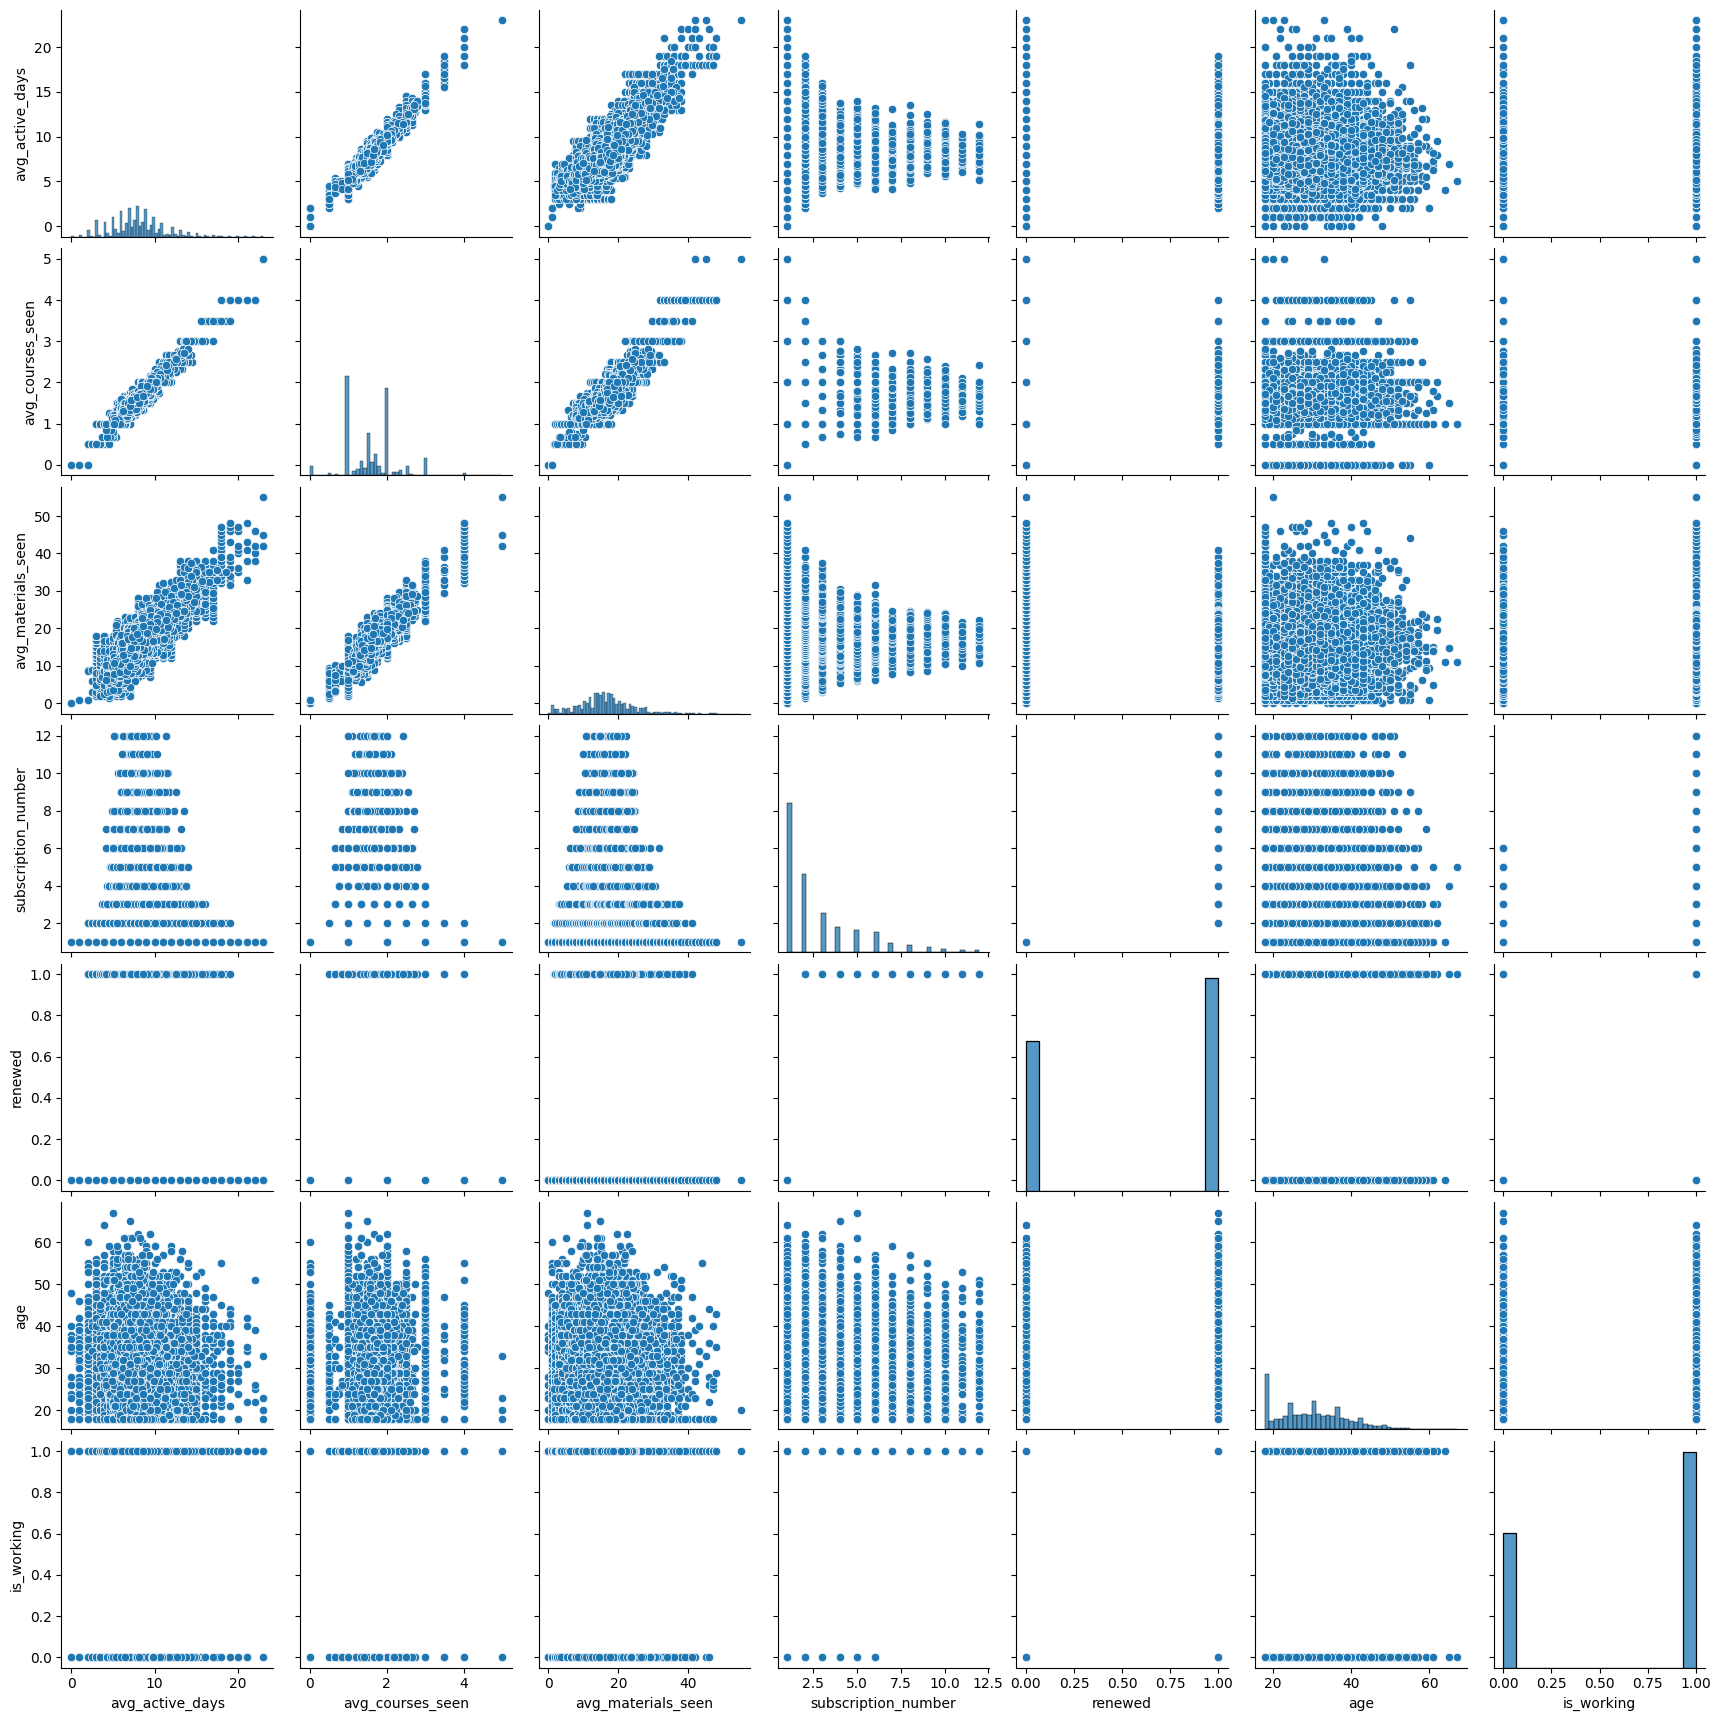

In [92]:
# Matriz de dispersogramas
sns.pairplot(df[['avg_active_days', 'avg_courses_seen', 'avg_materials_seen', 'subscription_number', 'renewed', 'age', 'is_working']])

Sólo tenemos una variable categórica la cual es _"favorite_category"_ al observar los datos agrupados por categoría obtenemos que, en efecto, las personas cuyo contenido favorito es ciencias de la computación tienden a renovar menos. Lo que es un factor relevante a la hora de establecer insights valiosos para aumentar la tasa de retención

In [93]:
# Agrupamos por categoría para observar cómo cambian los valores por cada una
df[['avg_active_days', 'avg_courses_seen', 'avg_materials_seen', 'subscription_number', 'renewed', 'age', 'is_working', 'favorite_category']].groupby('favorite_category').agg('mean')

,avg_active_days,avg_courses_seen,avg_materials_seen,subscription_number,renewed,age,is_working
favorite_category,,,,,,,
Computer Science,8.673870,1.738331,17.387612,2.726461,0.556775,29.927022,0.614271
English,7.484269,1.517364,15.226236,2.822430,0.612483,30.296061,0.615992
Marketing,7.409890,1.485449,14.981388,2.759860,0.604538,30.447469,0.616522


In [94]:
# Hacemos la codificación one hot para las variables categoricas
df = pd.concat([df, pd.get_dummies(df.favorite_category, dtype=int)], axis=1)
df.rename(columns={'Computer Science': 'computer_science', 'English': 'english', 'Marketing': 'marketing'}, inplace=True)

Como se identifica en la matriz de dispersogramas, las relaciones entre las variables tienden a no ser lineales, por lo que los coeficientes de correlación no serán muy útiles a la hora de identificar un modelo:

<Axes: >

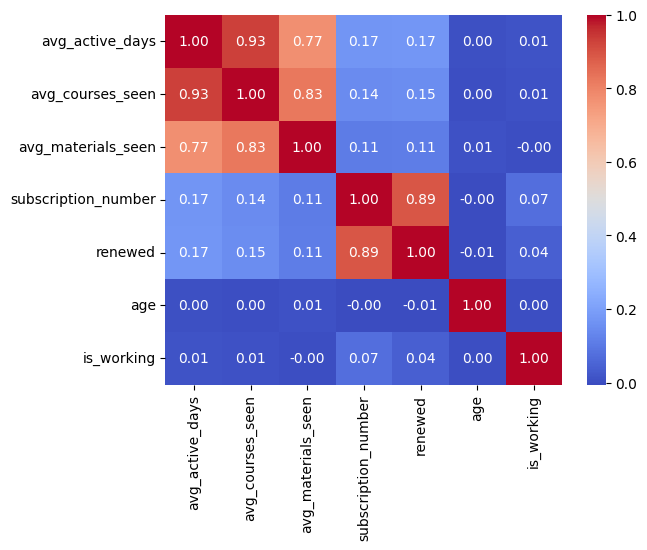

In [95]:
# Matriz de correlaciones
correlation_matrix = df[['avg_active_days', 'avg_courses_seen', 'avg_materials_seen', 'subscription_number', 'renewed', 'age', 'is_working']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

Dado esto, optamos por continuar con las siguientes variables:

**Variable explicada:**
- subscription_number
- renewed

**Variables explicativas:**
- avg_active_days
- avg_courses_seen
- avg_materials_seen
- is_working
- computer_science
- english
- marketing

#### Ajuste del Modelo

Hasta el momento sabemos que los usarios con un consumo medio en la plataforma tienden a renovar más. Si bien en sí esto ya es un conocimiento valioso seguramente surgirá las preguntas de ¿cuál es el consumo mínimo necesario para retener a un usuario?, ¿Y el máximo? Para conocer esto, nos servirá en gran medida ajustar un modelo a los datos, con el gran factor añadido de que nos permitirá predecir cuánto tiempo puede durar un individuo según sus patrones de consumo. 

En primer lugar, podemos descartar el uso del modelo de regresión lineal, no porque no sea útil en este caso, sino porque conociendo la no linealiad de las relaciones y la alta correlación entre algunas variables, sus conclusiones pueden llegar a ser sesgadas al no cumplirse a cabalidad sus supuestos. Si bien estos defectos se pueden corregir, dichas alternativas no suelen ser eficientes en un entorno productivo ya que su gasto computacional puede ser alto. Por otro lado, ya que necesitamos identificar los patrones que hacen que un individuo permanezca en la plataforma, no nos es util un modelo de redes neuronales. Dado esto, es buena idea optar por un modelo de Machine Learnig como el decisión tree, pues se basa en unas reglas fácilmente interpretables para realizar predicciones sobre un individuo.

##### Regresión
El uso de la regresión será identificar cuántos meses se espera que el usuario se encuentre en la plataforma. Muy útil para complementar el análisis de cohortes.

In [237]:
# Obtenemos las variables para regresión
df_fit = df[['subscription_number', 'avg_active_days', 'avg_courses_seen', 'avg_materials_seen', 'is_working', 'computer_science', 'english', 'marketing']]
df_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9801 entries, 0 to 9800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subscription_number  9801 non-null   int64  
 1   avg_active_days      9801 non-null   float64
 2   avg_courses_seen     9801 non-null   float64
 3   avg_materials_seen   9801 non-null   float64
 4   is_working           9505 non-null   float64
 5   computer_science     9801 non-null   int32  
 6   english              9801 non-null   int32  
 7   marketing            9801 non-null   int32  
dtypes: float64(4), int32(3), int64(1)
memory usage: 497.8 KB


In [238]:
# Partimos el dataframe en una parte de entrenamiento y otra de validación
x, x_test, y, y_test = train_test_split(df_fit.drop(columns='subscription_number'), df_fit['subscription_number'], test_size=0.3) 

Text(0, 0.5, 'Score')

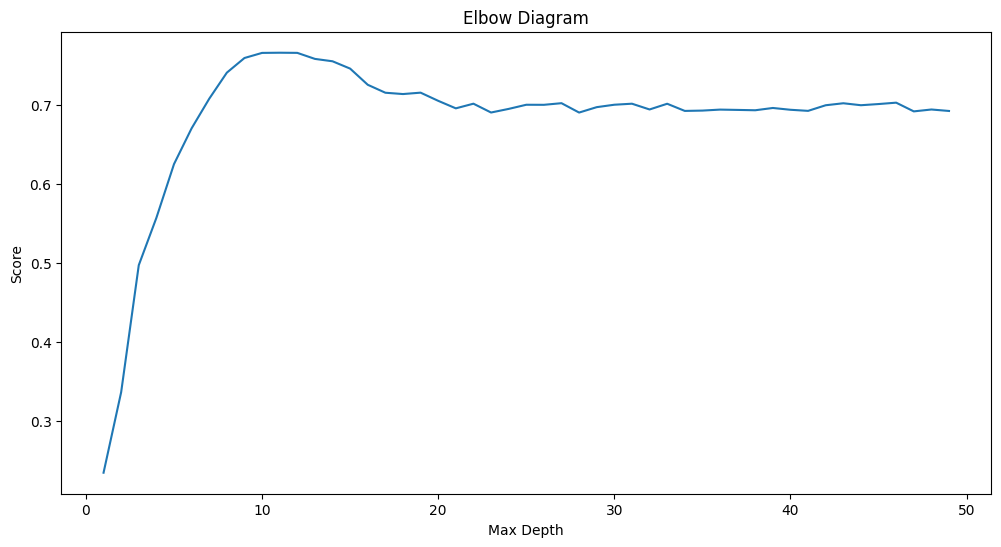

In [239]:
# Generamos un diagrama de codo para identificar el valor optimo del hiperparámetro
dept_list = list()
score_list = list()
for i in range(1, 50):
    regression_tree = tree.DecisionTreeRegressor(criterion='squared_error', max_depth=i)
    arbol = regression_tree.fit(x, y)
    temp = regression_tree.score(x_test, y_test)
    dept_list.append(i)
    score_list.append(temp)

plt.figure(figsize=(12,6))
plt.plot(dept_list, score_list)
plt.title('Elbow Diagram')
plt.xlabel('Max Depth')
plt.ylabel('Score')

In [240]:
# El hiperparámetro optimo es 10, pero se deja en 3 para visualizar fácilmente el arbol de decisión
regression_tree = tree.DecisionTreeRegressor(criterion='squared_error', max_depth=3)
arbol = regression_tree.fit(x, y)
regression_tree.score(x_test, y_test)

0.49692333949805134

[Text(0.5416666666666666, 0.875, 'is_working <= inf\nsquared_error = 5.371\nsamples = 6860\nvalue = 2.758'),
 Text(0.3333333333333333, 0.625, 'avg_courses_seen <= 1.05\nsquared_error = 4.374\nsamples = 6657\nvalue = 2.579'),
 Text(0.16666666666666666, 0.375, 'avg_active_days <= 4.083\nsquared_error = 0.806\nsamples = 2135\nvalue = 1.396'),
 Text(0.08333333333333333, 0.125, 'squared_error = 0.092\nsamples = 782\nvalue = 1.1'),
 Text(0.25, 0.125, 'squared_error = 1.138\nsamples = 1353\nvalue = 1.568'),
 Text(0.5, 0.375, 'avg_courses_seen <= 1.955\nsquared_error = 5.085\nsamples = 4522\nvalue = 3.138'),
 Text(0.4166666666666667, 0.125, 'squared_error = 5.107\nsamples = 2086\nvalue = 4.359'),
 Text(0.5833333333333334, 0.125, 'squared_error = 2.696\nsamples = 2436\nvalue = 2.092'),
 Text(0.75, 0.625, 'avg_courses_seen <= 0.875\nsquared_error = 2.589\nsamples = 203\nvalue = 8.626'),
 Text(0.6666666666666666, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 4.0'),
 Text(0.8333333333333334, 0

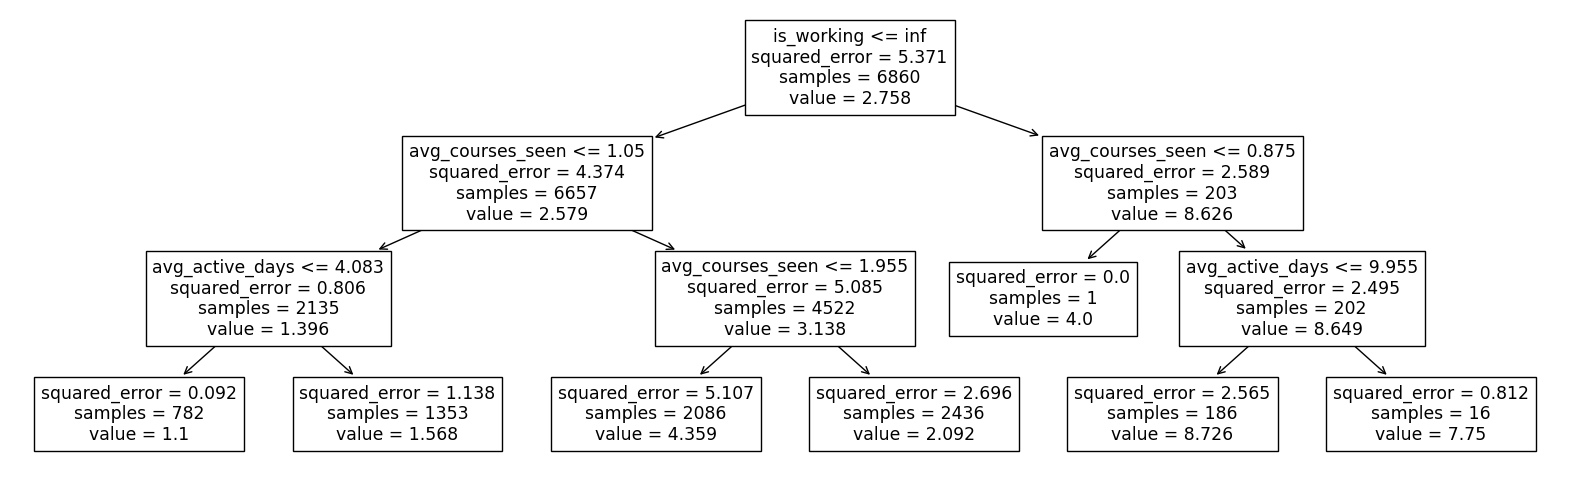

In [242]:
# Graficamos el arbol
plt.figure(figsize=(20,6))
tree.plot_tree(arbol, feature_names=x.columns)

##### Clasificación

Este modelo nos servirá para idenficar cuando un individuo está proximo a abandonar la plataforma expresándonos las reglas claras que toma en cuenta para identificar al individuo

In [243]:
df_fit = df[['renewed', 'avg_active_days', 'avg_courses_seen', 'avg_materials_seen', 'is_working', 'computer_science', 'english', 'marketing']]
x, x_test, y, y_test = train_test_split(df_fit.drop(columns='renewed'), df_fit['renewed'], test_size=0.3) 

Text(0, 0.5, 'Score')

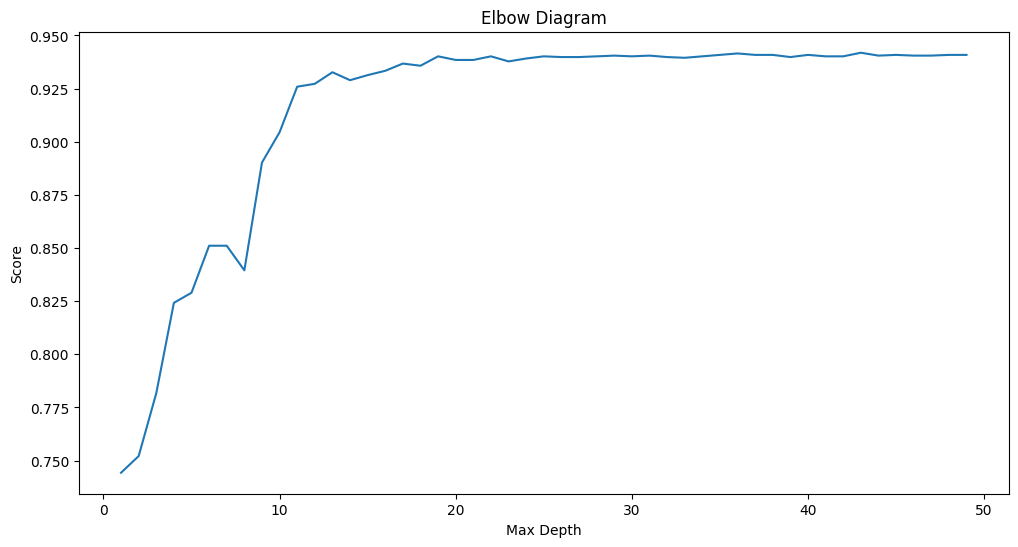

In [244]:
dept_list = list()
score_list = list()
for i in range(1, 50):
    regression_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    arbol = regression_tree.fit(x, y)
    temp = regression_tree.score(x_test, y_test)
    dept_list.append(i)
    score_list.append(temp)

plt.figure(figsize=(12,6))
plt.plot(dept_list, score_list)
plt.title('Elbow Diagram')
plt.xlabel('Max Depth')
plt.ylabel('Score')


In [245]:
# Nuevamente, el optimo está entre 10 y 15 pero se disminuye para observar fácilmente el arbol.
regression_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
arbol = regression_tree.fit(x, y)
regression_tree.score(x_test, y_test)

0.7817069024141449

[Text(0.5416666666666666, 0.875, 'avg_courses_seen <= 1.05\nentropy = 0.976\nsamples = 6860\nvalue = [2801.0, 4059.0]'),
 Text(0.3333333333333333, 0.625, 'avg_active_days <= 3.25\nentropy = 0.84\nsamples = 2090\nvalue = [1528, 562]'),
 Text(0.16666666666666666, 0.375, 'avg_courses_seen <= 0.75\nentropy = 0.227\nsamples = 463\nvalue = [446, 17]'),
 Text(0.08333333333333333, 0.125, 'entropy = 0.441\nsamples = 175\nvalue = [159, 16]'),
 Text(0.25, 0.125, 'entropy = 0.033\nsamples = 288\nvalue = [287, 1]'),
 Text(0.5, 0.375, 'avg_active_days <= 6.875\nentropy = 0.92\nsamples = 1627\nvalue = [1082, 545]'),
 Text(0.4166666666666667, 0.125, 'entropy = 0.968\nsamples = 1313\nvalue = [795, 518]'),
 Text(0.5833333333333334, 0.125, 'entropy = 0.423\nsamples = 314\nvalue = [287, 27]'),
 Text(0.75, 0.625, 'avg_courses_seen <= 1.958\nentropy = 0.837\nsamples = 4770\nvalue = [1273, 3497]'),
 Text(0.6666666666666666, 0.375, 'entropy = 0.0\nsamples = 2309\nvalue = [0, 2309]'),
 Text(0.8333333333333334,

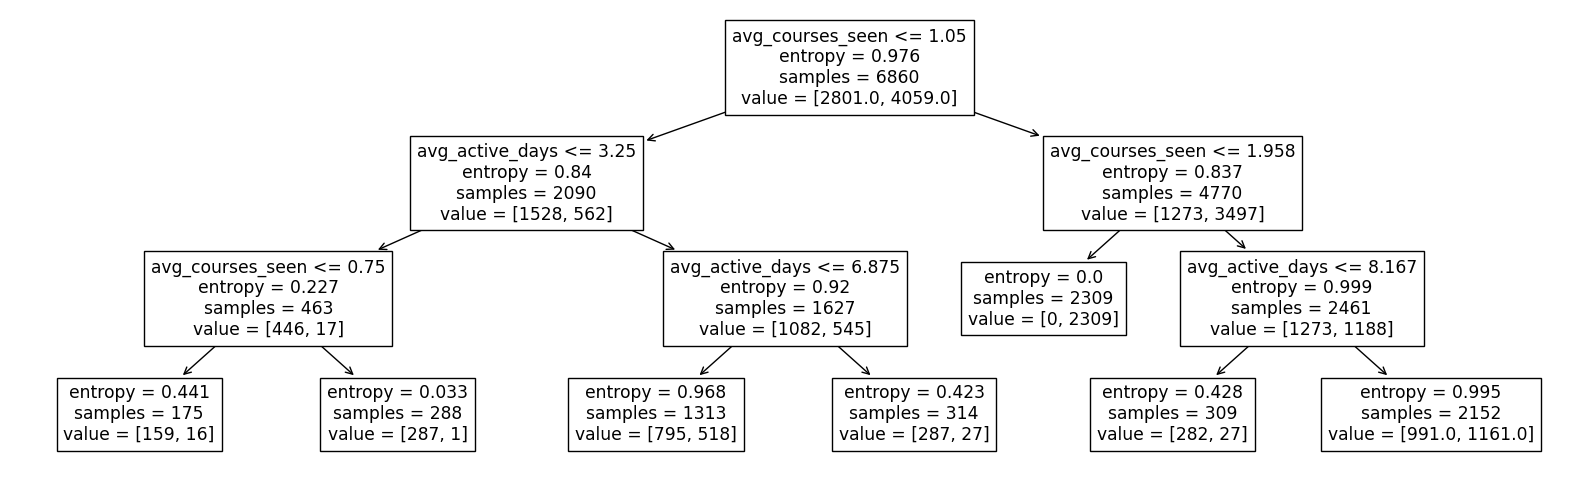

In [246]:
plt.figure(figsize=(20,6))
tree.plot_tree(arbol, feature_names=x.columns)

### **Solución**

Dado el análisis realizado previamente extraemos tres iniciativas para mejorar la retención de los usuarios:"
1. Los usuarios que que tienen un patron bajo de consumo tienden a renovar menos, al igual que aquellos que consumen mucho contenido en un mes. Por esto, desarrollar alertas a los usuarios que se salgan de un intervalo optimo puede afecar sus patrones de consumo normalizandolos y evitando que se vayan a puntos extremos, lo que disminuirá su tasa de abandono.
2. Los individuos que no trabajan tienden a abandonar más la plataforma. Dado esto, se pueden diseñar programas exclusivos: por ejemplo, grupos de aprendizaje que facilite conexiones laborales dentro de la plataforma.
3. Las personas que consumen cursos sobre ciencias de la computación son las personas que tienen más probabilidad de abandonar respescto a los demás grupos. Con la información actual no hay manera de idenficar a qué se debe esto, puede ser porque los cursos son de corta duración, no están al nivel que la audiencia desea o están muy por encima del nivel promedio de los usuarios. Para idenficar cuáles de estas razones pueden ser, es necesario reailzar un análisis de NPS.